In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
matches = pd.read_csv('../data/train.csv')

In [3]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60242 entries, 0 to 60241
Data columns (total 91 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            60242 non-null  int64  
 1   color                               60242 non-null  object 
 2   rank                                60242 non-null  object 
 3   map_code                            60242 non-null  object 
 4   duration                            60242 non-null  int64  
 5   car_name                            60242 non-null  object 
 6   possession_time                     60198 non-null  float64
 7   time_in_side                        60228 non-null  float64
 8   shots                               60242 non-null  int64  
 9   shots_against                       60242 non-null  int64  
 10  goals                               60242 non-null  int64  
 11  goals_against                       60242

**Goal:** Predict the rank based on the total shots.

In [4]:
matches_prepped = matches.groupby(['match_id', 'rank'])[['avg_speed', 'percent_supersonic_speed']].mean().reset_index()
matches_prepped.head()

,match_id,rank,avg_speed,percent_supersonic_speed
0,0,silver,1413.0,9.547984
1,1,gold,1346.0,8.922114
2,2,silver,1319.5,10.972618
3,3,platinum,1391.5,8.797042
4,4,platinum,1521.0,12.298239


In [5]:
matches.groupby(['rank'])['time_full_boost'].sum().reset_index()

,rank,time_full_boost
0,bronze,57108.73
1,champion,411851.57
2,diamond,517657.02
3,gold,520698.79
4,platinum,591736.32
5,silver,240704.46


In [6]:
matches['rank'].value_counts()

rank
platinum    14996
diamond     13832
gold        12504
champion    11756
silver       5680
bronze       1474
Name: count, dtype: int64

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score

class MultiColumnLabelEncoder(LabelEncoder):
    """
    Wraps sklearn LabelEncoder functionality for use on multiple columns of a
    pandas dataframe.

    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, dframe):
        """
        Fit label encoder to pandas columns.

        Access individual column classes via indexig `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            for idx, column in enumerate(self.columns):
                # fit LabelEncoder to get `classes_` for the column
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                # append this column's encoder
                self.all_encoders_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return self

    def fit_transform(self, dframe):
        """
        Fit label encoder and return encoded labels.

        Access individual column classes via indexing
        `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`

        Access individual column encoded labels via indexing
        `self.all_labels_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            self.all_labels_ = np.ndarray(shape=self.columns.shape,
                                          dtype=object)
            for idx, column in enumerate(self.columns):
                # instantiate LabelEncoder
                le = LabelEncoder()
                # fit and transform labels in the column
                dframe.loc[:, column] =\
                    le.fit_transform(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
                self.all_labels_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                dframe.loc[:, column] = le.fit_transform(
                        dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return dframe.loc[:, self.columns].values

    def transform(self, dframe):
        """
        Transform labels to normalized encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[
                    idx].transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .transform(dframe.loc[:, column].values)
        return dframe.loc[:, self.columns].values

    def inverse_transform(self, dframe):
        """
        Transform labels back to original encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        return dframe.loc[:, self.columns].values




# get `object` columns
X_object_columns = X.iloc[:, :].select_dtypes(include=['object']).columns
# df_copy_object_columns = X_copy.iloc[:, :].select_dtypes(include=['object']).columns

# instantiate `MultiColumnLabelEncoder`
mcle = MultiColumnLabelEncoder(columns=X_object_columns)

# fit to `df` data
mcle.fit(X)

# transform the `df` data
X_NumericOnly = mcle.transform(X)

X_NumericOnly

In [8]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [9]:
NumericColumns = matches.select_dtypes(include=[np.number]).columns.tolist()
NumericColumns_Without_MatchID = NumericColumns.pop(0)
NumericColumns

['duration',
 'possession_time',
 'time_in_side',
 'shots',
 'shots_against',
 'goals',
 'goals_against',
 'saves',
 'assists',
 'score',
 'shooting_percentage',
 'bpm',
 'bcpm',
 'avg_amount',
 'amount_collected',
 'amount_stolen',
 'amount_collected_big',
 'amount_stolen_big',
 'amount_collected_small',
 'amount_stolen_small',
 'count_collected_big',
 'count_stolen_big',
 'count_collected_small',
 'count_stolen_small',
 'amount_overfill',
 'amount_overfill_stolen',
 'amount_used_while_supersonic',
 'time_zero_boost',
 'percent_zero_boost',
 'time_full_boost',
 'percent_full_boost',
 'time_boost_0_25',
 'time_boost_25_50',
 'time_boost_50_75',
 'time_boost_75_100',
 'percent_boost_0_25',
 'percent_boost_25_50',
 'percent_boost_50_75',
 'percent_boost_75_100',
 'avg_speed',
 'total_distance',
 'time_supersonic_speed',
 'time_boost_speed',
 'time_slow_speed',
 'time_ground',
 'time_low_air',
 'time_high_air',
 'time_powerslide',
 'count_powerslide',
 'avg_powerslide_duration',
 'avg_spe

In [10]:
MatchAggregated_Matches = matches.groupby(['match_id', 'rank'])[NumericColumns].sum().reset_index()
MatchAggregated_Matches

,match_id,rank,duration,possession_time,time_in_side,shots,shots_against,goals,goals_against,saves,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,0,silver,326,82.46,139.64,6,6,5,5,1,...,126.313240,73.686768,144.689560,55.310446,193.838250,193.838250,193.838250,193.838250,1,1
1,1,gold,920,235.53,393.56,17,17,13,13,3,...,131.031125,68.968869,151.785120,48.214880,193.860950,193.860950,193.860950,193.860950,0,0
2,2,silver,188,43.25,81.11,3,3,3,3,0,...,131.124745,68.875258,144.769240,55.230766,187.390130,187.390130,187.390130,187.390130,0,0
3,3,platinum,686,229.37,301.88,12,12,8,8,3,...,125.121784,74.878216,152.124215,47.875778,195.873688,195.873688,195.873688,195.873688,2,2
4,4,platinum,732,260.79,330.97,16,16,7,7,5,...,120.835720,79.164277,151.986890,48.013109,196.647236,196.647236,196.647236,196.647236,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30116,30116,platinum,656,206.86,284.36,13,13,9,9,5,...,120.551075,79.448913,144.377590,55.622410,193.610440,193.610440,193.610440,193.610440,0,0
30117,30117,bronze,852,211.08,365.22,20,20,12,12,8,...,128.013235,71.986763,155.357760,44.642239,195.385700,195.385700,195.385700,195.385700,1,1
30118,30118,silver,780,249.92,344.39,14,14,9,9,5,...,119.381703,80.618304,142.307998,57.692005,196.069200,196.069200,196.069200,196.069200,1,1
30119,30119,silver,744,264.72,336.73,11,11,7,7,4,...,128.526040,71.473962,148.898055,51.101952,198.715385,198.715385,198.715385,198.715385,2,2


In [11]:
X = MatchAggregated_Matches.drop(columns = ['match_id', 'assists', 'shots_against']) #, 'map_code', 'car_name'])
y = MatchAggregated_Matches['rank']

In [12]:
X

,rank,duration,possession_time,time_in_side,shots,goals,goals_against,saves,score,shooting_percentage,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,silver,326,82.46,139.64,6,5,5,1,759,175.000000,...,126.313240,73.686768,144.689560,55.310446,193.838250,193.838250,193.838250,193.838250,1,1
1,gold,920,235.53,393.56,17,13,13,3,2355,155.714290,...,131.031125,68.968869,151.785120,48.214880,193.860950,193.860950,193.860950,193.860950,0,0
2,silver,188,43.25,81.11,3,3,3,0,469,100.000000,...,131.124745,68.875258,144.769240,55.230766,187.390130,187.390130,187.390130,187.390130,0,0
3,platinum,686,229.37,301.88,12,8,8,3,1599,111.111112,...,125.121784,74.878216,152.124215,47.875778,195.873688,195.873688,195.873688,195.873688,2,2
4,platinum,732,260.79,330.97,16,7,7,5,1909,87.500000,...,120.835720,79.164277,151.986890,48.013109,196.647236,196.647236,196.647236,196.647236,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30116,platinum,656,206.86,284.36,13,9,9,5,1794,120.000000,...,120.551075,79.448913,144.377590,55.622410,193.610440,193.610440,193.610440,193.610440,0,0
30117,bronze,852,211.08,365.22,20,12,12,8,2393,123.232324,...,128.013235,71.986763,155.357760,44.642239,195.385700,195.385700,195.385700,195.385700,1,1
30118,silver,780,249.92,344.39,14,9,9,5,1786,129.166664,...,119.381703,80.618304,142.307998,57.692005,196.069200,196.069200,196.069200,196.069200,1,1
30119,silver,744,264.72,336.73,11,7,7,4,1734,129.166664,...,128.526040,71.473962,148.898055,51.101952,198.715385,198.715385,198.715385,198.715385,2,2


In [13]:
y

0          silver
1            gold
2          silver
3        platinum
4        platinum
           ...   
30116    platinum
30117      bronze
30118      silver
30119      silver
30120    platinum
Name: rank, Length: 30121, dtype: object

In [14]:
X.describe()

,duration,possession_time,time_in_side,shots,goals,goals_against,saves,score,shooting_percentage,bpm,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
count,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,...,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000,30121.000000
mean,675.070549,206.912483,295.183740,14.219349,8.560108,8.560108,4.330899,1769.317055,118.735062,803.716543,...,123.472350,76.527650,149.608880,50.391120,195.010990,195.010990,195.010990,195.010990,1.239003,1.239003
std,191.509433,63.849973,82.298856,5.107314,3.511116,3.511116,2.618905,598.571317,33.969061,101.071180,...,4.918667,4.918667,5.754766,5.754766,2.864088,2.864088,2.864088,2.864088,1.343723,1.343723
min,120.000000,0.000000,19.890000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,28.000000,...,84.657612,18.451400,94.165260,18.388399,94.780597,94.780597,94.780597,94.780597,0.000000,0.000000
25%,588.000000,177.720000,258.240000,11.000000,6.000000,6.000000,2.000000,1405.000000,98.571428,749.000000,...,120.328049,73.687727,146.128726,46.769396,194.081600,194.081600,194.081600,194.081600,0.000000,0.000000
50%,742.000000,229.490000,332.960000,15.000000,9.000000,9.000000,4.000000,1828.000000,118.181814,814.000000,...,123.271144,76.728854,149.736150,50.263841,195.337731,195.337731,195.337731,195.337731,1.000000,1.000000
75%,804.000000,251.340000,349.780000,18.000000,11.000000,11.000000,6.000000,2184.000000,140.000000,871.000000,...,126.312286,79.671956,153.230600,53.871281,196.360160,196.360160,196.360160,196.360160,2.000000,2.000000
max,1786.000000,514.460000,724.290000,64.000000,60.000000,60.000000,20.000000,7512.000000,700.000000,1186.000000,...,181.548600,115.342390,181.611610,105.834743,225.567464,225.567464,225.567464,225.567464,33.000000,33.000000


scaler = StandardScaler()


le_y = LabelEncoder()

y_fitted = le_y.fit(y)
y_encoded = le_y.fit_transform(y)


X_NumericOnly = X.drop(columns = ['rank'])
X_Numeric_Top30_MostInfluential = X_NumericOnly[['percent_supersonic_speed', 'bcpm', 'percent_infront_ball', 'percent_low_air', 'percent_ground', 'avg_powerslide_duration', 'percent_boost_speed', 'percent_behind_ball', 'saves', 'count_powerslide', 'time_supersonic_speed', 'avg_distance_to_ball_no_possession', 'avg_speed', 'percent_boost_75_100', 'avg_distance_to_ball', 'shots', 'percent_offensive_half', 'percent_full_boost', 'avg_speed_percentage', 'percent_boost_0_25', 'amount_used_while_supersonic', 'time_infront_ball', 'amount_collected_small', 'score', 'percent_zero_boost', 'percent_boost_50_75', 'time_boost_75_100', 'percent_defensive_half', 'time_boost_speed', 'goals_against_while_last_defender']] 
X_Numeric_Top30_MostInfluential_ColumnsReordered = X_Numeric_Top30_MostInfluential.reindex(columns = ['percent_supersonic_speed', 'bcpm', 'percent_infront_ball', 'percent_low_air', 'percent_ground', 'avg_powerslide_duration', 'percent_boost_speed', 'percent_behind_ball', 'saves', 'count_powerslide', 'time_supersonic_speed', 'avg_distance_to_ball_no_possession', 'avg_speed', 'percent_boost_75_100', 'avg_distance_to_ball', 'shots', 'percent_offensive_half', 'percent_full_boost', 'avg_speed_percentage', 'percent_boost_0_25', 'amount_used_while_supersonic', 'time_infront_ball', 'amount_collected_small', 'score', 'percent_zero_boost', 'percent_boost_50_75', 'time_boost_75_100', 'percent_defensive_half', 'time_boost_speed', 'goals_against_while_last_defender'])


X_Numeric_Top30_MostInfluential_Fitted = scaler.fit(X_Numeric_Top30_MostInfluential_ColumnsReordered)
X_Numeric_Top30_MostInfluential_Transformed = scaler.fit_transform(X_Numeric_Top30_MostInfluential_ColumnsReordered)

X_train, X_test, y_train, y_test = train_test_split(X_Numeric_Top30_MostInfluential_Transformed, y_encoded, test_size = 0.5, random_state = 321, shuffle=True, stratify = y_encoded)

In [15]:
scaler = StandardScaler()


le_y = LabelEncoder()

y_fitted = le_y.fit(y)
y_encoded = le_y.fit_transform(y)


X_NumericOnly = X.drop(columns = ['rank'])
X_Numeric_Top30_MostInfluential = X_NumericOnly 
X_Numeric_Top30_MostInfluential_ColumnsReordered = X_Numeric_Top30_MostInfluential
# # X_Numeric_Top30_MostInfluential.reindex(columns = ['percent_supersonic_speed', 'bcpm', 'percent_infront_ball', 'percent_low_air', 'percent_ground', 'avg_powerslide_duration', 'percent_boost_speed', 'percent_behind_ball', 'saves', 'count_powerslide', 'time_supersonic_speed', 'avg_distance_to_ball_no_possession', 'avg_speed', 'percent_boost_75_100', 'avg_distance_to_ball', 'shots', 'percent_offensive_half', 'percent_full_boost', 'avg_speed_percentage', 'percent_boost_0_25', 'amount_used_while_supersonic', 'time_infront_ball', 'amount_collected_small', 'score', 'percent_zero_boost', 'percent_boost_50_75', 'time_boost_75_100', 'percent_defensive_half', 'time_boost_speed', 'goals_against_while_last_defender'])


# X_Numeric_Top30_MostInfluential_Fitted = scaler.fit(X_Numeric_Top30_MostInfluential_ColumnsReordered)
X_Numeric_Top30_MostInfluential_Transformed = scaler.fit_transform(X_Numeric_Top30_MostInfluential_ColumnsReordered)

X_train, X_test, y_train, y_test = train_test_split(X_Numeric_Top30_MostInfluential_Transformed, y_encoded, test_size = 0.2, random_state = 321, shuffle=True, stratify = y_encoded)

In [16]:
X_NumericOnly

,duration,possession_time,time_in_side,shots,goals,goals_against,saves,score,shooting_percentage,bpm,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,326,82.46,139.64,6,5,5,1,759,175.000000,716,...,126.313240,73.686768,144.689560,55.310446,193.838250,193.838250,193.838250,193.838250,1,1
1,920,235.53,393.56,17,13,13,3,2355,155.714290,750,...,131.031125,68.968869,151.785120,48.214880,193.860950,193.860950,193.860950,193.860950,0,0
2,188,43.25,81.11,3,3,3,0,469,100.000000,808,...,131.124745,68.875258,144.769240,55.230766,187.390130,187.390130,187.390130,187.390130,0,0
3,686,229.37,301.88,12,8,8,3,1599,111.111112,828,...,125.121784,74.878216,152.124215,47.875778,195.873688,195.873688,195.873688,195.873688,2,2
4,732,260.79,330.97,16,7,7,5,1909,87.500000,776,...,120.835720,79.164277,151.986890,48.013109,196.647236,196.647236,196.647236,196.647236,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30116,656,206.86,284.36,13,9,9,5,1794,120.000000,699,...,120.551075,79.448913,144.377590,55.622410,193.610440,193.610440,193.610440,193.610440,0,0
30117,852,211.08,365.22,20,12,12,8,2393,123.232324,604,...,128.013235,71.986763,155.357760,44.642239,195.385700,195.385700,195.385700,195.385700,1,1
30118,780,249.92,344.39,14,9,9,5,1786,129.166664,707,...,119.381703,80.618304,142.307998,57.692005,196.069200,196.069200,196.069200,196.069200,1,1
30119,744,264.72,336.73,11,7,7,4,1734,129.166664,911,...,128.526040,71.473962,148.898055,51.101952,198.715385,198.715385,198.715385,198.715385,2,2


In [17]:
y_encoded

array([5, 3, 5, ..., 5, 5, 4], shape=(30121,))


param_dist = {
    'max_depth': range(4, 6, 1),
    'min_child_weight':range(3, 5, 1),
    'learning_rate': [0.05, 0.0563, 0.06],
    'subsample':[i/10.0 for i in range(4, 6)],
    'colsample_bytree':[i/10.0 for i in range(3, 5)],
    'n_estimators':[185, 190, 195, 200, 205],
    'gamma':[i/10.0 for i in range(1, 2)],
   # 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_alpha':[0, -0.0001, -0.001]
    
}



xgb_model = XGBClassifier()

# Create the RandomizedSearchCV object
GridSearch = GridSearchCV(  estimator = xgb_model, 
                            param_grid = param_dist, 
                            scoring='accuracy',
                            verbose = 2,
                            n_jobs = -1)

# Fit the RandomizedSearchCV object to the training data
GridSearch.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", GridSearch.best_params_)
print("Best score: ", GridSearch.best_score_)






In [18]:
xgb = XGBClassifier(learning_rate = 0.105,
                    colsample_bytree = 0.8,
                    gamma = 0.1,
                    max_depth = 4,
                    min_child_weight = 3,
                    reg_alpha = 0.01,
                    n_estimators = 190,
                    subsample = 0.6,
                    eval_metric='mlogloss'
                                        
                    
                    ).fit(X_train, y_train)

In [19]:
from sklearn.feature_selection import SelectFromModel

In [20]:
selection = SelectFromModel(xgb, threshold=0.01, prefit=True)

In [21]:
X_selected = selection.transform(X_train)
X_selected

array([[-0.82615224, -0.12635212,  0.2006882 , ...,  0.39882239,
        -0.39391667,  0.39391633],
       [ 0.54445403,  0.63733852, -0.50179868, ...,  0.11176748,
         1.02026693, -1.02026605],
       [ 0.54445403, -0.50819745,  0.3095242 , ...,  0.05431741,
        -0.06332083,  0.06332083],
       ...,
       [-1.21775403, -0.89004277,  0.33920674, ..., -1.38154339,
        -0.21859819,  0.21859611],
       [ 0.54445403,  1.78287448,  0.65582055, ...,  0.64894512,
        -0.53418536,  0.53418762],
       [-0.63035134, -0.50819745,  0.37878347, ..., -0.92585104,
         0.47415239, -0.4741536 ]], shape=(24096, 28))

In [22]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

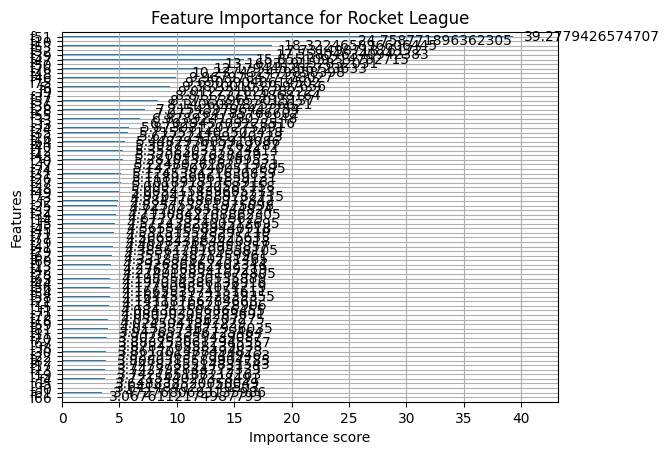

In [23]:
plot_importance_object = plot_importance(xgb, importance_type='gain')
plt.title('Feature Importance for Rocket League')
plt.show()

In [24]:
feature_importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_Numeric_Top30_MostInfluential_Transformed.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_30_features = feature_importance_df.head(30)

print(top_30_features)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
print("Top 30 features:", top_30_features['Feature'].tolist())

Top 30 features: ['percent_supersonic_speed', 'bcpm', 'percent_low_air', 'percent_ground', 'time_supersonic_speed', 'avg_powerslide_duration', 'percent_boost_speed', 'percent_infront_ball', 'avg_speed_percentage', 'count_powerslide', 'percent_behind_ball', 'saves', 'bpm', 'avg_speed', 'avg_distance_to_ball_no_possession', 'percent_boost_75_100', 'percent_full_boost', 'avg_distance_to_ball', 'percent_boost_0_25', 'shots', 'amount_used_while_supersonic', 'percent_boost_50_75', 'amount_collected_small', 'time_infront_ball', 'time_boost_speed', 'amount_collected', 'time_low_air', 'count_collected_small', 'score', 'percent_offensive_half']


In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
le_y

LabelEncoder()

In [ ]:
y_fitted

LabelEncoder()

In [ ]:
y_encoded

array([5, 3, 5, ..., 5, 5, 4], shape=(30121,))

In [ ]:
y

0          silver
1            gold
2          silver
3        platinum
4        platinum
           ...   
30116    platinum
30117      bronze
30118      silver
30119      silver
30120    platinum
Name: rank, Length: 30121, dtype: object

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
accuracy_score(y_test, y_pred)

0.5495435684647303

In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 56,   0,   1,  18,   2,  70],
       [  0, 780, 356,   1,  38,   1],
       [  1, 314, 708,  36, 323,   1],
       [ 10,   4,  45, 709, 358, 125],
       [  3,  38, 350, 334, 766,   9],
       [ 33,   0,   1, 215,  27, 292]])

In [ ]:
print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.54      0.38      0.45       147
           1       0.69      0.66      0.67      1176
           2       0.48      0.51      0.50      1383
           3       0.54      0.57      0.55      1251
           4       0.51      0.51      0.51      1500
           5       0.59      0.51      0.55       568

    accuracy                           0.55      6025
   macro avg       0.56      0.52      0.54      6025
weighted avg       0.55      0.55      0.55      6025



In [ ]:
scores = cross_val_score(xgb, X_Numeric_Top30_MostInfluential_ColumnsReordered, y_encoded, cv=10, scoring='accuracy')

In [ ]:
print('Cross Validation Accuracy Scores:', scores)

Cross Validation Accuracy Scores: [0.5645536  0.55212483 0.56175299 0.55776892 0.53187251 0.55245684
 0.54913679 0.55478088 0.53519256 0.53652058]


Now that I'm happy with the results, I want to refit the model on all of the available training data.

In [ ]:
test = pd.read_csv('../data/test.csv')

In [ ]:
test

,match_id,color,map_code,duration,car_name,possession_time,time_in_side,shots,shots_against,goals,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,30121,blue,utopiastadium_p,400,Octane,105.06,194.75,8,9,6,...,66.643970,33.356037,75.814224,24.185778,97.731575,97.731575,97.731575,97.731575,0,1
1,30121,orange,utopiastadium_p,400,Fennec,137.27,149.39,9,8,5,...,60.714287,39.285713,75.197850,24.802143,97.676710,97.676710,97.676710,97.676710,1,0
2,30122,blue,cs_day_p,355,Octane,109.79,169.13,3,5,3,...,62.784500,37.215504,74.585790,25.414206,98.727340,98.727340,98.727340,98.727340,1,2
3,30122,orange,cs_day_p,355,Octane,142.90,160.31,5,3,2,...,55.250595,44.749400,71.672920,28.327084,98.757010,98.757010,98.757010,98.757010,2,1
4,30123,blue,wasteland_s_p,206,Fennec,68.06,79.30,2,7,1,...,63.022804,36.977196,67.308720,32.691280,96.396400,96.396400,96.396400,96.396400,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,32618,orange,utopiastadium_p,309,Octane,104.96,171.93,4,7,2,...,68.542650,31.457352,72.559784,27.440212,97.214035,97.214035,97.214035,97.214035,2,0
4996,32619,blue,cs_day_p,395,Octane,129.85,188.64,4,10,3,...,68.351326,31.648680,68.960846,31.039158,98.099884,98.099884,98.099884,98.099884,1,1
4997,32619,orange,cs_day_p,395,Fennec,118.85,160.41,10,4,6,...,55.080130,44.919870,78.544044,21.455957,98.045120,98.045120,98.045120,98.045120,1,1
4998,32620,blue,chn_stadium_p,361,Dominus,165.17,150.74,2,7,2,...,60.910637,39.089360,76.314390,23.685608,98.478615,98.478615,98.478615,98.478615,1,1


In [ ]:
FreshTest_MatchAggregated_Matches = test.groupby(['match_id'])[NumericColumns].sum().reset_index()
FreshTest_MatchAggregated_Matches

,match_id,duration,possession_time,time_in_side,shots,shots_against,goals,goals_against,saves,assists,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,30121,800,242.33,344.14,17,17,11,11,4,0,...,127.358257,72.641750,151.012074,48.987921,195.408285,195.408285,195.408285,195.408285,1,1
1,30122,710,252.69,329.44,8,8,5,5,3,0,...,118.035095,81.964904,146.258710,53.741290,197.484350,197.484350,197.484350,197.484350,3,3
2,30123,412,133.79,178.87,9,9,6,6,2,0,...,119.691410,80.308586,147.550420,52.449579,192.739810,192.739810,192.739810,192.739810,0,0
3,30124,184,49.29,81.69,5,5,3,3,2,0,...,121.093815,78.906189,160.284490,39.715519,192.569590,192.569590,192.569590,192.569590,0,0
4,30125,654,202.73,281.47,10,10,9,9,2,0,...,122.944644,77.055346,148.812370,51.187633,195.210420,195.210420,195.210420,195.210420,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,32616,686,269.93,318.31,11,11,5,5,5,0,...,121.332752,78.667233,151.086150,48.913858,197.398700,197.398700,197.398700,197.398700,1,1
2496,32617,242,49.58,92.88,6,6,6,6,0,0,...,130.336984,69.663008,151.244784,48.755222,186.102780,186.102780,186.102780,186.102780,0,0
2497,32618,618,211.11,279.42,11,11,7,7,4,0,...,121.769520,78.230477,150.480094,49.519893,194.428070,194.428070,194.428070,194.428070,2,2
2498,32619,790,248.70,349.05,14,14,9,9,5,0,...,123.431456,76.568550,147.504890,52.495115,196.145004,196.145004,196.145004,196.145004,2,2


In [ ]:
X_fresh_test = FreshTest_MatchAggregated_Matches.drop(columns = ['match_id', 'assists', 'shots_against'])
X_fresh_test


,duration,possession_time,time_in_side,shots,goals,goals_against,saves,score,shooting_percentage,bpm,...,percent_defensive_half,percent_offensive_half,percent_behind_ball,percent_infront_ball,percent_most_back,percent_most_forward,percent_closest_to_ball,percent_farthest_from_ball,demos_inflicted,demos_taken
0,800,242.33,344.14,17,11,11,4,2096,130.555557,860,...,127.358257,72.641750,151.012074,48.987921,195.408285,195.408285,195.408285,195.408285,1,1
1,710,252.69,329.44,8,5,5,3,1282,140.000000,726,...,118.035095,81.964904,146.258710,53.741290,197.484350,197.484350,197.484350,197.484350,3,3
2,412,133.79,178.87,9,6,6,2,1180,121.428570,809,...,119.691410,80.308586,147.550420,52.449579,192.739810,192.739810,192.739810,192.739810,0,0
3,184,49.29,81.69,5,3,3,2,652,100.000000,806,...,121.093815,78.906189,160.284490,39.715519,192.569590,192.569590,192.569590,192.569590,0,0
4,654,202.73,281.47,10,9,9,2,1880,166.666664,854,...,122.944644,77.055346,148.812370,51.187633,195.210420,195.210420,195.210420,195.210420,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,686,269.93,318.31,11,5,5,5,1458,83.333332,746,...,121.332752,78.667233,151.086150,48.913858,197.398700,197.398700,197.398700,197.398700,1,1
2496,242,49.58,92.88,6,6,6,0,804,100.000000,800,...,130.336984,69.663008,151.244784,48.755222,186.102780,186.102780,186.102780,186.102780,0,0
2497,618,211.11,279.42,11,7,7,4,1594,121.428570,981,...,121.769520,78.230477,150.480094,49.519893,194.428070,194.428070,194.428070,194.428070,2,2
2498,790,248.70,349.05,14,9,9,5,1938,135.000000,797,...,123.431456,76.568550,147.504890,52.495115,196.145004,196.145004,196.145004,196.145004,2,2


In [ ]:
y

0          silver
1            gold
2          silver
3        platinum
4        platinum
           ...   
30116    platinum
30117      bronze
30118      silver
30119      silver
30120    platinum
Name: rank, Length: 30121, dtype: object

In [ ]:
y_encoded.shape

(30121,)

In [ ]:
X_fresh_test.shape

(2500, 83)

In [ ]:
X_FreshTest_Numeric_Top30_MostInfluential = X_fresh_test[['percent_supersonic_speed', 'bcpm', 'percent_infront_ball', 'percent_low_air', 'percent_ground', 'avg_powerslide_duration', 'percent_boost_speed', 'percent_behind_ball', 'saves', 'count_powerslide', 'time_supersonic_speed', 'avg_distance_to_ball_no_possession', 'avg_speed', 'percent_boost_75_100', 'avg_distance_to_ball', 'shots', 'percent_offensive_half', 'percent_full_boost', 'avg_speed_percentage', 'percent_boost_0_25', 'amount_used_while_supersonic', 'time_infront_ball', 'amount_collected_small', 'score', 'percent_zero_boost', 'percent_boost_50_75', 'time_boost_75_100', 'percent_defensive_half', 'time_boost_speed', 'goals_against_while_last_defender']]
X_FreshTest_Numeric_Top30_MostInfluential_ColumnsReordered = X_FreshTest_Numeric_Top30_MostInfluential.reindex(columns = ['percent_supersonic_speed', 'bcpm', 'percent_infront_ball', 'percent_low_air', 'percent_ground', 'avg_powerslide_duration', 'percent_boost_speed', 'percent_behind_ball', 'saves', 'count_powerslide', 'time_supersonic_speed', 'avg_distance_to_ball_no_possession', 'avg_speed', 'percent_boost_75_100', 'avg_distance_to_ball', 'shots', 'percent_offensive_half', 'percent_full_boost', 'avg_speed_percentage', 'percent_boost_0_25', 'amount_used_while_supersonic', 'time_infront_ball', 'amount_collected_small', 'score', 'percent_zero_boost', 'percent_boost_50_75', 'time_boost_75_100', 'percent_defensive_half', 'time_boost_speed', 'goals_against_while_last_defender'])

In [ ]:
X_FreshTest_Numeric_Top30_MostInfluential_ColumnsReordered

,percent_supersonic_speed,bcpm,percent_infront_ball,percent_low_air,percent_ground,avg_powerslide_duration,percent_boost_speed,percent_behind_ball,saves,count_powerslide,...,amount_used_while_supersonic,time_infront_ball,amount_collected_small,score,percent_zero_boost,percent_boost_50_75,time_boost_75_100,percent_defensive_half,time_boost_speed,goals_against_while_last_defender
0,27.914693,892.66803,48.987921,77.659187,115.730404,0.22,77.513183,151.012074,4,125,...,749,194.90,1154,2096,32.594561,28.851499,175.35,127.358257,308.31,11.0
1,19.602157,738.85314,53.741290,66.957978,126.805008,0.35,75.788238,146.258710,3,87,...,630,188.36,779,1282,20.932095,28.239789,255.77,118.035095,265.68,5.0
2,31.415245,852.78218,52.449579,87.078979,105.311542,0.23,85.661388,147.550420,2,59,...,220,108.09,658,1180,21.293058,34.763493,117.76,119.691410,176.52,6.0
3,29.443067,930.35480,39.715519,69.736204,122.904910,0.25,74.996492,160.284490,2,25,...,131,36.75,282,652,32.182536,25.906812,56.58,121.093815,69.40,3.0
4,28.518992,913.91525,51.187633,80.526939,112.616394,0.22,70.604427,148.812370,2,107,...,734,167.30,1119,1880,29.802169,21.183360,140.28,122.944644,230.76,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,15.375553,736.21894,48.913858,77.953293,116.684830,0.42,70.159673,151.086150,5,65,...,512,167.32,853,1458,25.224701,26.159565,160.09,121.332752,239.84,5.0
2496,38.813203,935.44954,48.755222,85.531979,108.814975,0.30,64.934635,151.244784,0,33,...,84,58.02,346,804,22.732991,15.335478,55.02,130.336984,77.86,6.0
2497,34.386223,963.81363,49.519893,85.245820,107.034801,0.19,76.642698,150.480094,4,145,...,666,151.23,1659,1594,30.833015,29.181843,139.76,121.769520,233.99,7.0
2498,16.130643,814.14963,52.495115,77.463294,117.706702,0.31,81.259844,147.504890,5,75,...,750,205.30,1219,1938,35.549229,30.063481,196.62,123.431456,317.81,9.0


In [ ]:
X_FreshTest_Transformed = scaler.transform(X_FreshTest_Numeric_Top30_MostInfluential_ColumnsReordered)
X_FreshTest_Transformed

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- amount_collected
- amount_collected_big
- amount_overfill
- amount_overfill_stolen
- amount_stolen
- ...


In [ ]:
y_pred_fresh_test = xgb.predict(X_FreshTest_Transformed)

In [ ]:
y_pred_fresh_test

array([2, 3, 4, ..., 1, 3, 4], shape=(2500,))

In [ ]:
# remapping/reassigning numbers to ranks, in order to be consistent with the way that Michael assigned/mapped the ranks

converter = { 0:1, 5:2, 3:3, 4:4, 2:5, 1:6 }

y_pred_fresh_test = pd.Series(y_pred_fresh_test).map(converter)

In [ ]:
y_pred_fresh_test

0       5
1       3
2       4
3       4
4       5
       ..
2495    4
2496    6
2497    6
2498    3
2499    4
Length: 2500, dtype: int64

In [ ]:
# converter = { 'bronze': 1, 'silver': 2, 'gold': 3, 'platinum': 4, 'diamond': 5, 'champion': 6 }

# y_pred = pd.Series(y_pred).map(converter)

In [ ]:
y_pred_fresh_test_df = pd.DataFrame(y_pred_fresh_test, columns = ['rank'])
y_pred_fresh_test_df

,rank
0,5
1,3
2,4
3,4
4,5
...,...
2495,4
2496,6
2497,6
2498,3


In [ ]:
submission_AlmostReady = pd.concat([FreshTest_MatchAggregated_Matches['match_id'], y_pred_fresh_test_df], axis = 1).rename(columns = {0: 'rank'})
submission_AlmostReady

,match_id,rank
0,30121,5
1,30122,3
2,30123,4
3,30124,4
4,30125,5
...,...,...
2495,32616,4
2496,32617,6
2497,32618,6
2498,32619,3


In [ ]:
NaN_count = submission_AlmostReady.isna().sum()
NaN_count

match_id    0
rank        0
dtype: int64

In [ ]:
mode_value = submission_AlmostReady['rank'].mode()[0]
submission = submission_AlmostReady.fillna(mode_value).astype(int)
submission

,match_id,rank
0,30121,5
1,30122,3
2,30123,4
3,30124,4
4,30125,5
...,...,...
2495,32616,4
2496,32617,6
2497,32618,6
2498,32619,3


In [ ]:
submission.to_csv('../data/submission_TunedHyperparameter_Top30Features_XGBoostClassifier_TopFeaturesSelector_Apr18Ver.csv', index = False)